<a href="https://colab.research.google.com/github/batiukmaks/Computer-Vision-Labs/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Input, concatenate, BatchNormalization, Activation, Dropout, MaxPool2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [ ]:
# Load and preprocess Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
lenet_model = Sequential([
    Conv2D(6, kernel_size=5, activation='relu', input_shape=(28, 28, 1), padding='same'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=5, activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

lenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lenet_model.fit(x_train, y_train_cat, batch_size=128, epochs=10, validation_data=(x_test, y_test_cat))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.6711 - loss: 0.9385 - val_accuracy: 0.8082 - val_loss: 0.5190
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.8358 - loss: 0.4540 - val_accuracy: 0.8487 - val_loss: 0.4099
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.8589 - loss: 0.3879 - val_accuracy: 0.8668 - val_loss: 0.3710
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.8752 - loss: 0.3420 - val_accuracy: 0.8718 - val_loss: 0.3506
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.8862 - loss: 0.3149 - val_accuracy: 0.8790 - val_loss: 0.3332
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8927 - loss: 0.2934 - val_accuracy: 0.8783 - val_loss: 0.3305
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8954 - loss: 0.2881 - val_accuracy: 0.8758 - val_loss: 0.3341
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.9010 - loss: 0.2729 - 

In [ ]:
train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_test)]

def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

In [ ]:
img_in = Input(shape=(28, 28, 1), name='FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8 * 2**i, kernel_size=(3, 3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16 * 2**i, kernel_size=(3, 3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2, 2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation='linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')

In [ ]:
img_a_in = Input(shape=(28, 28, 1), name='ImageA_Input')
img_b_in = Input(shape=(28, 28, 1), name='ImageB_Input')
img_a_feat = feature_model(img_a_in)[0]
img_b_feat = feature_model(img_b_in)[0]
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

In [ ]:
import tensorflow as tf

def siam_gen(in_groups, batch_size=32):
    def generator():
        while True:
            a, b, sim = gen_random_batch(in_groups, batch_size // 2)
            yield ((a.astype(np.float32), b.astype(np.float32)), sim.astype(np.float32))  # ✅ строго tuple всередині
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (
                tf.TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32),
                tf.TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32)
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )



train_ds = siam_gen(train_groups, batch_size=32)
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)

loss_history = similarity_model.fit(
    train_ds,
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.6915 - mae: 0.4890

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['FeatureNet_ImageInput']
Received: inputs=Tensor(shape=(32, 28, 28, 1))
  warnings.warn(msg)


500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - loss: 0.6914 - mae: 0.4890 - val_loss: 0.5338 - val_mae: 0.3918
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - loss: 0.5509 - mae: 0.3980 - val_loss: 0.4244 - val_mae: 0.2923
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - loss: 0.4588 - mae: 0.3179 - val_loss: 0.3933 - val_mae: 0.2667
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - loss: 0.4330 - mae: 0.2914 - val_loss: 0.3712 - val_mae: 0.2474
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - loss: 0.4038 - mae: 0.2680 - val_loss: 0.3619 - val_mae: 0.2369
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - loss: 0.3949 - mae: 0.2600 - val_loss: 0.3564 - val_mae: 0.2381
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - loss: 0.3860 - mae: 0.2539 - val_loss: 0.3415 - val_mae: 0.2229
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - loss: 0.3826 - mae: 0.2507 - val_loss: 0.3401 - val_mae: 0.2163
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/s

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.093516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.264481
[t-SNE] KL divergence after 500 iterations: 1.489768


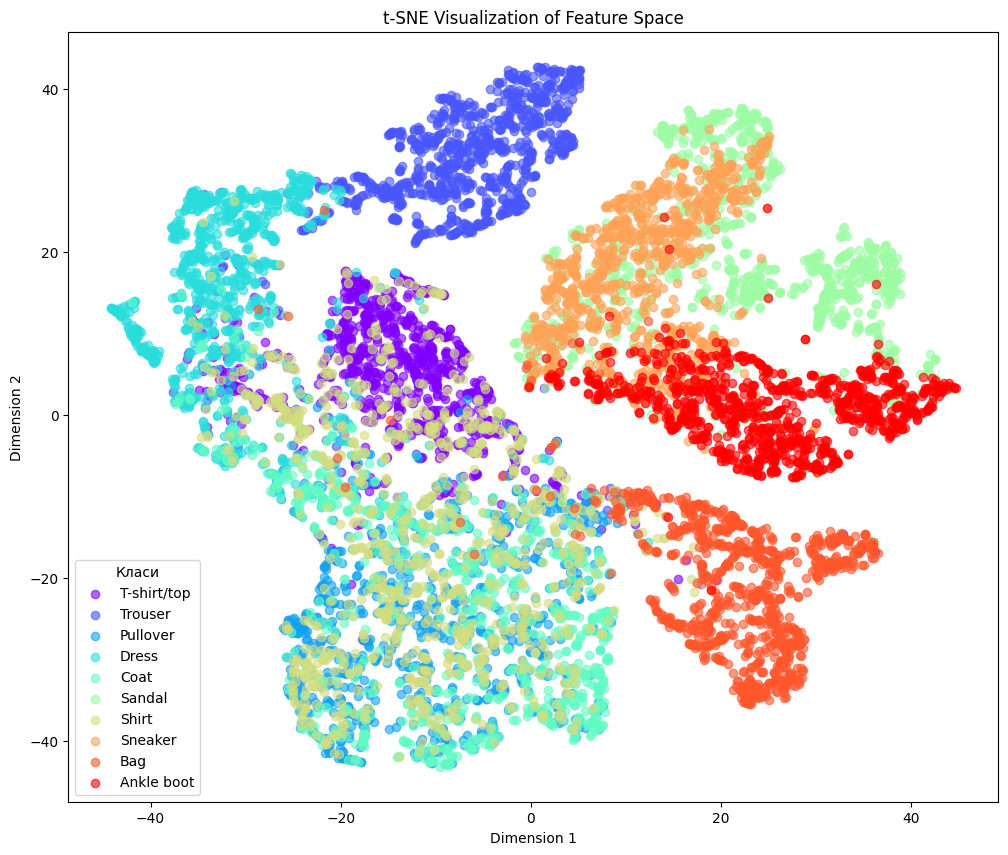

In [ ]:
# t-SNE Plot (t-distributed stochastic neighbor embedding)
x_test_features = feature_model.predict(x_test, verbose=True, batch_size=128)
tsne = TSNE(n_components=2, init='pca', random_state=101, method='barnes_hut', n_iter=500, verbose=1)
tsne_features = tsne.fit_transform(x_test_features)

# Visualize t-SNE
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(12, 10))
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(tsne_features[idx, 0], tsne_features[idx, 1],
                color=color, label=class_names[i], alpha=0.6)
plt.legend(title="Класи")
plt.title("t-SNE Visualization of Feature Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


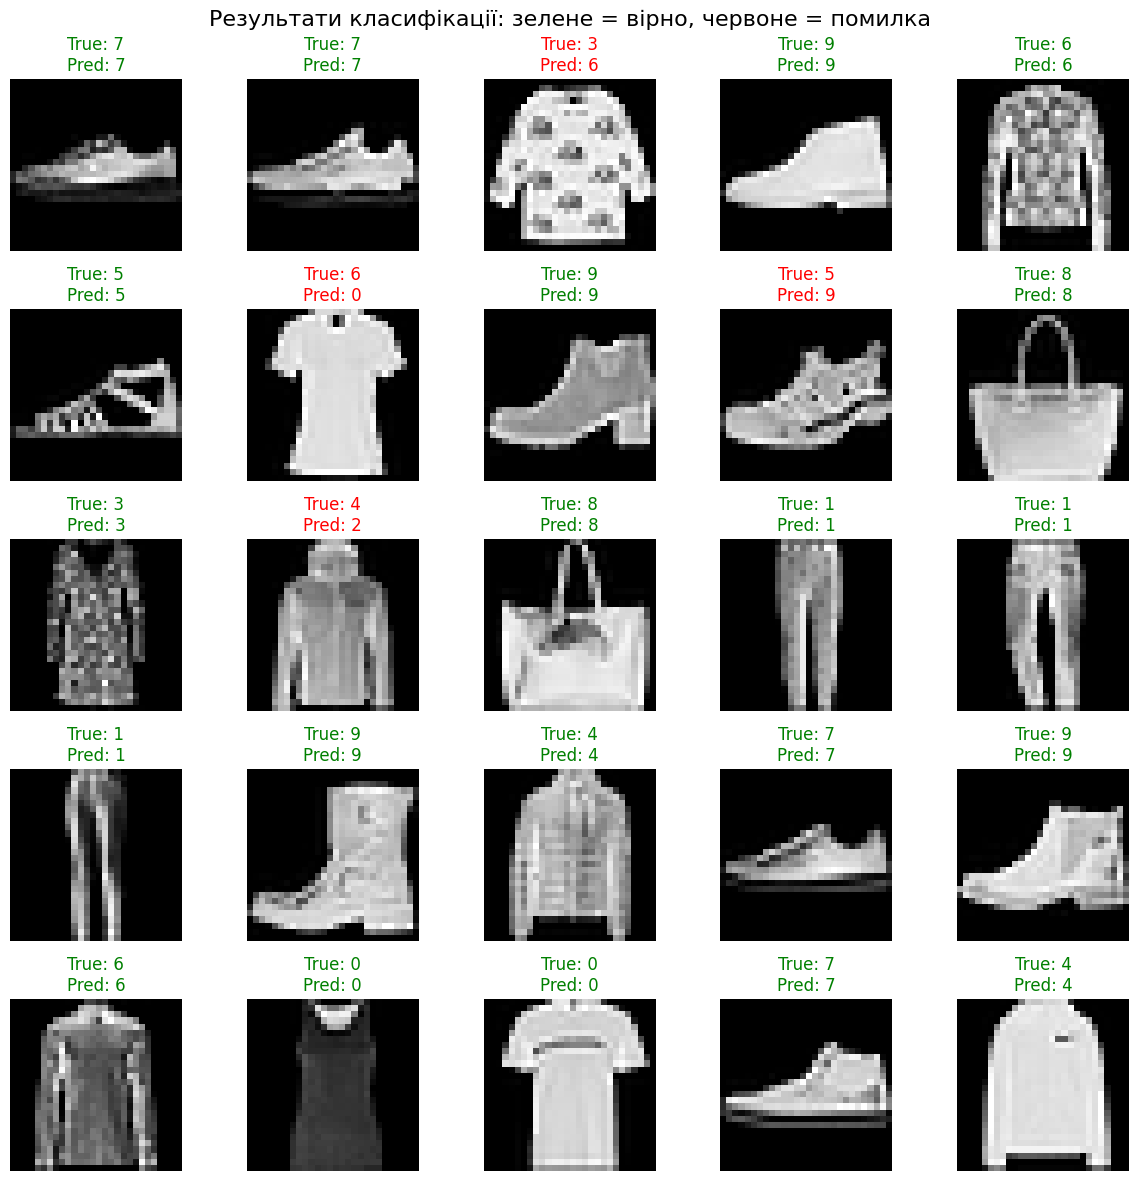

In [ ]:
import random

# Передбачення моделі LeNet-5
pred_probs = lenet_model.predict(x_test)
pred_labels = pred_probs.argmax(axis=1)

# Кількість зображень для виводу
n = 25
indices = random.sample(range(len(x_test)), n)

# Побудова графіку
plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')
    true_label = y_test[idx]
    pred_label = pred_labels[idx]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
plt.suptitle("Результати класифікації: зелене = вірно, червоне = помилка", fontsize=16)
plt.tight_layout()
plt.show()
